# Modeling NLP Exercises

- What other types of models (i.e. different classifcation algorithms) could you use?
- How do the models compare when trained on term frequency data alone, instead of TF-IDF values?
- Try other model types

    [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
    ([`sklearn`
    docs](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html))
    is a very popular classifier for NLP tasks.
    - Model Types to try
        - SVM
        - XGboost
        - Random forrest
    

- Look at other metrics, is accuracy the best choice here?

- Try ngrams instead of single words

- Try a combination of ngrams and words (`ngram_range=(1, 2)` for words and
  bigrams)

- Try using tf-idf instead of bag of words

- Combine the top `n` performing words with the other features that you have
  engineered (the `CountVectorizer` and `TfidfVectorizer` have a `vocabulary`
  argument you can use to restrict the words used)

    ```python
    best_words = (
        # or, e.g. lm.coef_
        pd.Series(dict(zip(cv.get_feature_names(), tree.feature_importances_)))
        .sort_values()
        .tail(5)
        .index
    )

    cv = CountVectorizer(vocabulary=best_words)
    X = cv.fit_transform(df.text.apply(clean).apply(' '.join))

    # for demonstration
    pd.DataFrame(X.todense(), columns=cv.get_feature_names())
    ```

In [89]:
# IMPORTS
import pandas as pd
import numpy as np
import nltk
import re
from pprint import pprint

# imports for NLP extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

## Set up mini example from the Lesson

In [10]:
def clean(text: str) -> list:
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = set(nltk.corpus.stopwords.words('english'))
    text = (text.encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # tokenization
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

## Data Representation

Simple data for demonstration.

In [11]:
data = [
    'Python is pretty cool',
    'Python is a nice programming language with nice syntax',
    'I think SQL is cool too',
]

### Bag of Words

In [12]:
cv = CountVectorizer()
bag_of_words = cv.fit_transform(data)
bag_of_words

<3x12 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

### TF-IDF

- a measure that helps identify how important a word is in a document
- combination of how often a word appears in a document (**tf**) and how unqiue the word
  is among documents (**idf**)
- used by search engines
- naturally helps filter out stopwords
- tf is for a single document, idf is for a corpus

TF - Term Frequency

IDF - Inverse Document Frequency

In [13]:
tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(data)

pprint(data)
pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']


,cool,is,language,nice,pretty,programming,python,sql,syntax,think,too,with
0,0.480458,0.373119,0.000000,0.000000,0.631745,0.000000,0.480458,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.197673,0.334689,0.669378,0.000000,0.334689,0.254540,0.000000,0.334689,0.000000,0.000000,0.334689
2,0.383770,0.298032,0.000000,0.000000,0.000000,0.000000,0.000000,0.504611,0.000000,0.504611,0.504611,0.000000


### Bag Of Ngrams

For either `CountVectorizer` or `TfidfVectorizer`, you can set the `ngram_range`
parameter.

In [14]:
cv = CountVectorizer(ngram_range=(2, 2))
bag_of_words = cv.fit_transform(data)

In [15]:
pprint(data)
pd.DataFrame(bag_of_words.todense(), columns=cv.get_feature_names())

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']


,cool too,is cool,is nice,is pretty,language with,nice programming,nice syntax,pretty cool,programming language,python is,sql is,think sql,with nice
0,0,0,0,1,0,0,0,1,0,1,0,0,0
1,0,0,1,0,1,1,1,0,1,1,0,0,1
2,1,1,0,0,0,0,0,0,0,0,1,1,0


In [18]:
# changing the n_gram range, First number is the lowest amount of ngrams
# second is the highest
cv = CountVectorizer(ngram_range=(1, 3))
bag_of_words = cv.fit_transform(data)

In [17]:
pprint(data)
pd.DataFrame(bag_of_words.todense(), columns=cv.get_feature_names())

['Python is pretty cool',
 'Python is a nice programming language with nice syntax',
 'I think SQL is cool too']


,cool,cool too,is,is cool,is nice,is pretty,language,language with,nice,nice programming,...,python,python is,sql,sql is,syntax,think,think sql,too,with,with nice
0,1,0,1,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,1,1,2,1,...,1,1,0,0,1,0,0,0,1,1
2,1,1,1,1,0,0,0,0,0,0,...,0,0,1,1,0,1,1,1,0,0


## Spam setup from Lesson

In [19]:
df = pd.read_csv('spam_clean.csv')

In [20]:
cv = CountVectorizer()
X = cv.fit_transform(df.text.apply(clean).apply(' '.join))
y = df.label

# only a 2 split here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=12)

tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)

tree.score(X_train, y_train)

0.9306708548350908

In [21]:
tree.score(X_test, y_test)

0.9147982062780269

In [64]:
# import splitting functions for data set 
import acquire as a
import prepare as p

def banana_split(df):
    '''
    args: df
    This function takes in a dataframe and splits it into
    Train Validate and test dataframes
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=713)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=713)
    print(f'train --> {train.shape}')
    print(f'validate --> {validate.shape}')
    print(f'test --> {test.shape}')
    return train, validate, test

def all_aboard_the_X_train(X_cols, y_col, train, validate, test):
    '''
    X_cols = list of column names you want as your features
    y_col = string that is the name of your target column
    train = the name of your train dataframe
    validate = the name of your validate dataframe
    test = the name of your test dataframe
    outputs X_train and y_train, X_validate and y_validate, and X_test and y_test
    6 variables come out! So have that ready
    '''
    
    # do the capital X lowercase y thing for train test and split
    # X is the data frame of the features, y is a series of the target
    X_train, y_train = train[X_cols], train[y_col]
    X_validate, y_validate = validate[X_cols], validate[y_col]
    X_test, y_test = test[X_cols], test[y_col]
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test



def nlp_X_train_split(X_data, y_data):
    '''
    This function is designed for splitting data during an NLP pipeline
    It takes in the X_data (already transformed by your Vectorizer)
    y_data (target)
    And performs a train validate test X/y split (FOR MODELING NOT EXPLORATION)
    This is a one shot for doing train validate test and x/y split in one go
    
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    
    Returns 6 dfs: X_train, y_train, X_validate, y_validate, X_test, y_test
    '''
    X_train_validate, X_test, y_train_validate, y_test = train_test_split(X_data, y_data, 
                                                                          stratify = y_data, 
                                                                          test_size=.2, random_state=713)
    
    X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, 
                                                                stratify = y_train_validate, 
                                                                test_size=.3, 
                                                                random_state=713)
    
    return X_train, y_train, X_validate, y_validate, X_test, y_test

In [27]:
# prep dataframe 
df = p.prep_nlp(df, content = 'text')

### X and Y Setup
- To set up X and y we need to chose a count vectorizer of some sort 

```python
cv = CountVectorizer() # bag of words
cv = CountVectorizer(ngram_range=(2, 3)) # bag of ngrams (range sets up how many words) this is bi and tri grams
tfidf = TfidfVectorizer() # TF - IDF 
```

- Then we have to fit on the entire dataset 
    - unlike before this is just transforming the data so it's all the same
    - we're not leaking any data
- Create the X and y sets split into Train, validate and Test, then X_train, y_train and all that 
    - STRATIFY on y (this will be classification) 

In [42]:
# set up X and y

tfidf = TfidfVectorizer()

X_data = tfidf.fit_transform(df.lemmatized)

y_data = df.label

In [65]:
# use function from above (need to put in a module)
# split to X/y datasets 

X_train, y_train, X_validate, y_validate, X_test, y_test = nlp_X_train_split(X_data, y_data)

In [76]:
# Fit on Train

rforest = RandomForestClassifier()

rforest.fit(X_train, y_train)

# Check with Validate

rforest.score(X_validate, y_validate)

0.9715994020926756

### Creating the Models

In [104]:
def test_a_model(X_train, y_train, X_validate, y_validate, model, model_name, score_df):
    '''
    Function takes in X and y train
    X and y validate (or test) 
    A model with it's hyper parameters
    And a df to store the scores 
    '''
    this_model = model

    this_model.fit(X_train, y_train)

    # Check with Validate

    train_score = this_model.score(X_train, y_train)
    
    validate_score = this_model.score(X_validate, y_validate)
    
    model_dict = {'model_name': model_name, 
                  'train_score': train_score, 
                  'validate_score':validate_score}
    score_df = score_df.append(model_dict, ignore_index = True)
    
    return score_df

In [109]:
# set up the dataframe for the function
score_df = pd.DataFrame(columns = ['model_name', 'train_score', 'validate_score'])

- DecisionTreeClassifier
- MultinomialNB
- RandomForestClassifier
- LinearSVC

In [110]:
model_list = [MultinomialNB(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier()]

model_names = ['Naive_Bayes1', 'SVC1', 'Decision_tree1', 'Random_forest1']

In [111]:
for model, name in zip(model_list, model_names):
    score_df = test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)

In [112]:
score_df

,model_name,train_score,validate_score
0,Naive_Bayes1,0.964732,0.942451
1,SVC1,0.999679,0.975336
2,Decision_tree1,1.000000,0.957399
3,Random_forest1,1.000000,0.968610


In [113]:
class_names = np.array(['spam', 'ham'])

In [126]:
def print_metrics(model, X, y, pred, set_name = 'This Set'):
    
    # change your class names here
    class_names = np.array(['spam', 'ham'])
    
    print(model)
    print(f"~~~~~~~~{set_name} Scores~~~~~~~~~")
    print(classification_report(y, pred))
    
    #purple_cmap = sns.cubehelix_palette(as_cmap=True)
    purple_cmap = sns.color_palette("light:maroon", as_cmap=True)
    
    with sns.axes_style("white"):
        matrix = plot_confusion_matrix(model,X, y, display_labels=class_names, 
                                       cmap = purple_cmap)
        plt.grid(False)
        plt.show()
        print()

In [127]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [132]:
def make_models_and_print_metrics(model, model_name, X_train, y_train, X_validate, y_validate):
    model.fit(X_train, y_train)

    #predict for train and validate
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_validate)
    
    print(f'                   ============== {model_name} ================           ')
    #see metrics for train
    print_metrics(model, X_train, y_train, train_pred, set_name='Train')
    #print metrics for validate
    print_metrics(model, X_validate, y_validate, val_pred, set_name='Validate')
    print('-------------------------------------------------------------------\n')

                   ============== Naive_Bayes1 ================           
MultinomialNB()
~~~~~~~~Train Scores~~~~~~~~~
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      2701
        spam       1.00      0.74      0.85       418

    accuracy                           0.96      3119
   macro avg       0.98      0.87      0.91      3119
weighted avg       0.97      0.96      0.96      3119



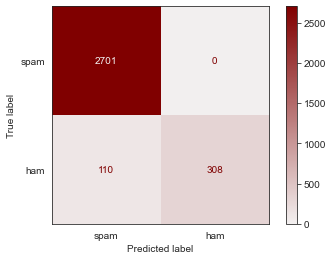


MultinomialNB()
~~~~~~~~Validate Scores~~~~~~~~~
              precision    recall  f1-score   support

         ham       0.94      1.00      0.97      1158
        spam       1.00      0.57      0.73       180

    accuracy                           0.94      1338
   macro avg       0.97      0.79      0.85      1338
weighted avg       0.95      0.94      0.94      1338



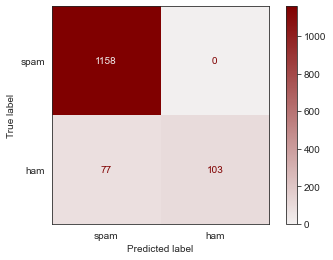


-------------------------------------------------------------------

                   ============== SVC1 ================           
LinearSVC()
~~~~~~~~Train Scores~~~~~~~~~
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      2701
        spam       1.00      1.00      1.00       418

    accuracy                           1.00      3119
   macro avg       1.00      1.00      1.00      3119
weighted avg       1.00      1.00      1.00      3119



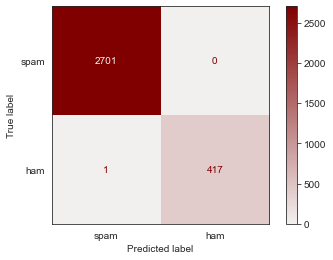


LinearSVC()
~~~~~~~~Validate Scores~~~~~~~~~
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1158
        spam       0.97      0.84      0.90       180

    accuracy                           0.98      1338
   macro avg       0.97      0.92      0.94      1338
weighted avg       0.98      0.98      0.97      1338



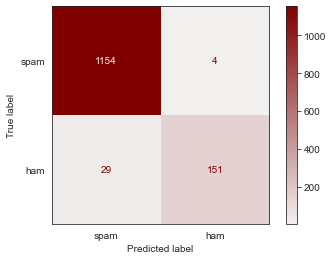


-------------------------------------------------------------------

                   ============== Decision_tree1 ================           
DecisionTreeClassifier()
~~~~~~~~Train Scores~~~~~~~~~
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      2701
        spam       1.00      1.00      1.00       418

    accuracy                           1.00      3119
   macro avg       1.00      1.00      1.00      3119
weighted avg       1.00      1.00      1.00      3119



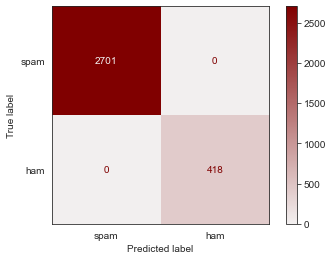


DecisionTreeClassifier()
~~~~~~~~Validate Scores~~~~~~~~~
              precision    recall  f1-score   support

         ham       0.97      0.97      0.97      1158
        spam       0.83      0.82      0.82       180

    accuracy                           0.95      1338
   macro avg       0.90      0.90      0.90      1338
weighted avg       0.95      0.95      0.95      1338



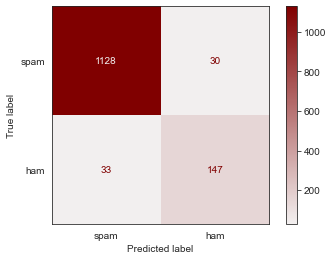


-------------------------------------------------------------------

                   ============== Random_forest1 ================           
RandomForestClassifier()
~~~~~~~~Train Scores~~~~~~~~~
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00      2701
        spam       1.00      1.00      1.00       418

    accuracy                           1.00      3119
   macro avg       1.00      1.00      1.00      3119
weighted avg       1.00      1.00      1.00      3119



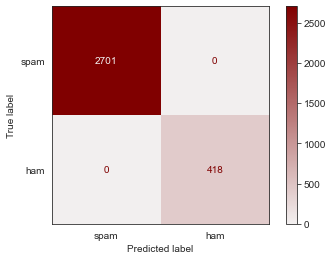


RandomForestClassifier()
~~~~~~~~Validate Scores~~~~~~~~~
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1158
        spam       0.99      0.81      0.89       180

    accuracy                           0.97      1338
   macro avg       0.98      0.90      0.94      1338
weighted avg       0.97      0.97      0.97      1338



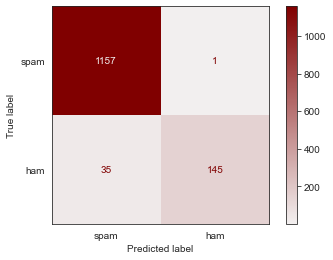


-------------------------------------------------------------------



In [133]:
for model, name in zip(model_list, model_names):
    score_df = test_a_model(X_train, y_train, X_validate, y_validate, model, name, score_df)
    
    make_models_and_print_metrics(model, name, X_train, y_train, X_validate, y_validate)